In [1]:
%matplotlib inline
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from os.path import join, isfile

import matplotlib.pyplot as plt

In [2]:
data_path = '/home/ymm/kaggle/bosch/data_1_bins_cross_fit_xgb_models/data_bin_0_models'

In [7]:
def collect_feature_names(data_path, fea_name='feature', thres_name = None, thres = 10):
    csv_files = [f for f in os.listdir(data_path) if '.csv' in f]
    feature_names = set()
    for file_name in csv_files:
        data = pd.read_csv(join(data_path, file_name), index_col=0)
        if thres_name is None:
            feature_names = feature_names.union(data[fea_name])
        else:
            feature_names = feature_names.union(data.loc[data[thres_name] > thres, fea_name])
            
    return feature_names


def combine_feature_importance_files(data_path, fea_name='feature', thres_name = None, thres = 10):
    csv_files = [f for f in os.listdir(data_path) if '.csv' in f]
    fea_imp = None
    file_counter = -1
    score_columns = []
    for file_name in csv_files:
        data = pd.read_csv(join(data_path, file_name), index_col=0)
        
        if thres_name is not None:
            data = data.loc[data[thres_name] > thres]
            
        data = data.set_index(fea_name)
        print data.shape
        file_counter += 1
        data.columns = ['{}_{}'.format(column, file_counter) for column in data.columns]
        score_columns.append('{}_{}'.format('fscore', file_counter))
        if fea_imp is None:
            fea_imp = data
        else:
            fea_imp = pd.merge(fea_imp, data, how='outer', left_index=True, right_index=True)
    
    fea_imp['fscore_sum'] = fea_imp[score_columns].sum(axis=1)
    return fea_imp



def combine_feature_score(data_path, fea_name='feature', score_name = None):
    csv_files = [f for f in os.listdir(data_path) if '.csv' in f]
    fea_score = None
    
    for i, file_name in enumerate(csv_files):
        data = pd.read_csv(join(data_path, file_name), index_col=0)
        data = data.set_index([fea_name])
        col_name = '{}_{}'.format(score_name, i)
        
        if fea_score is None:
            fea_score = pd.DataFrame()
        
        fea_score[col_name] = data[score_name]

            #fea_score = pd.merge(fea_score, data, how='outer', left_index=True, right_index=True)
            
    return fea_score

In [8]:
#tmp = combine_feature_importance_files(data_path)
combined_imp = combine_feature_importance_files(data_path, thres_name = 'fscore')

(321, 2)
(322, 2)
(325, 2)
(320, 2)


In [9]:
print combined_imp.shape
combined_imp.tail()

(370, 9)


,fscore_0,norm_fscore_0,fscore_1,norm_fscore_1,fscore_2,norm_fscore_2,fscore_3,norm_fscore_3,fscore_sum
feature,,,,,,,,,
L3_S50_D4242,18.0,0.000333,17.0,0.000311,59.0,0.001101,12.0,0.000219,106.0
L3_S50_F4243,14.0,0.000259,45.0,0.000823,27.0,0.000504,22.0,0.000402,108.0
L3_S50_F4253,12.0,0.000222,16.0,0.000293,NaN,NaN,NaN,NaN,28.0
L3_S51_D4255,NaN,NaN,14.0,0.000256,12.0,0.000224,11.0,0.000201,37.0
start_time,1464.0,0.027046,3051.0,0.055816,1708.0,0.031879,2975.0,0.054302,9198.0


In [19]:
top_variable = combined_imp.sort('fscore_sum')[-300:].index

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [20]:
for col in top_variable:
    if col in train_cat_cols.columns:
        print col

L3_S29_F3317
L3_S35_F3907
L3_S49_F4217
L3_S35_F3902
L3_S32_F3851
L3_S32_F3854


In [15]:
raw_data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'
sample_submission_file   = 'sample_submission.csv'

start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'

train_cat_cols = pd.read_csv(join(raw_data_path, train_cat_file), index_col=id_column_name, nrows=0)
train_date_cols = pd.read_csv(join(raw_data_path, train_date_file), index_col=id_column_name, nrows=0)
train_num_cols = pd.read_csv(join(raw_data_path, train_num_file), index_col=id_column_name, nrows=0)

In [50]:
## important column disribution
print sum(train_num_cols.columns.isin(combined_imp.index)), sum(train_cat_cols.columns.isin(combined_imp.index)), sum(train_date_cols.columns.isin(combined_imp.index))

291 12 66


In [63]:
selected_cat_col_names = train_cat_cols.columns[train_cat_cols.columns.isin(combined_imp.index)]

In [64]:
selected_combined_imp = combined_imp.ix[selected_cat_col_names]

In [65]:
print selected_combined_imp.shape
selected_combined_imp.head()

(12, 8)


,fscore_0,norm_fscore_0,fscore_1,norm_fscore_1,fscore_2,norm_fscore_2,fscore_3,norm_fscore_3
L2_S26_F3038,NaN,NaN,19.0,0.000348,NaN,NaN,NaN,NaN
L2_S27_F3131,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.000274
L3_S29_F3317,14.0,0.000259,13.0,0.000238,11.0,0.000205,29.0,0.000529
L3_S29_F3475,NaN,NaN,17.0,0.000311,NaN,NaN,14.0,0.000256
L3_S32_F3851,100.0,0.001847,190.0,0.003476,89.0,0.001661,141.0,0.002574


In [70]:
bin_NaN_data_path = '/home/ymm/kaggle/bosch/data_2_bins_xgb_combined_models/data_bin_NaN_models'
combined_nan_imp = combine_feature_importance_files(bin_NaN_data_path, thres_name = 'fscore')

(516, 2)
(515, 2)
(512, 2)
(514, 2)
(513, 2)


In [73]:
common_col_names = set(combined_nan_imp.index).intersection(set(combined_imp.index))

In [76]:
print len(combined_imp.index), len(common_col_names), len(combined_nan_imp)

370 200 568


In [77]:
combined_nan_imp.ix[common_col_names]

,fscore_0,norm_fscore_0,fscore_1,norm_fscore_1,fscore_2,norm_fscore_2,fscore_3,norm_fscore_3,fscore_4,norm_fscore_4
feature,,,,,,,,,,
L2_S26_F3106,200.0,0.004508,207.0,0.004660,229.0,0.005204,215.0,0.004894,208.0,0.004723
L3_S43_F4090,11.0,0.000248,13.0,0.000293,NaN,NaN,NaN,NaN,12.0,0.000273
L3_S43_F4095,12.0,0.000270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L2_S27_F3155,83.0,0.001871,78.0,0.001756,65.0,0.001477,86.0,0.001957,76.0,0.001726
L3_S31_F3842,44.0,0.000992,41.0,0.000923,42.0,0.000954,41.0,0.000933,48.0,0.001090
L3_S34_F3882,14.0,0.000316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L3_S30_F3819,142.0,0.003200,155.0,0.003489,135.0,0.003068,160.0,0.003642,141.0,0.003202
L3_S30_F3804,313.0,0.007054,340.0,0.007654,307.0,0.006976,292.0,0.006646,307.0,0.006972
L3_S41_F4006,28.0,0.000631,28.0,0.000630,27.0,0.000614,36.0,0.000819,26.0,0.000590


In [81]:
combined_nan_imp.head()

,fscore_0,norm_fscore_0,fscore_1,norm_fscore_1,fscore_2,norm_fscore_2,fscore_3,norm_fscore_3,fscore_4,norm_fscore_4
feature,,,,,,,,,,
L0_S12_F330,159.0,0.003584,177.0,0.003985,128.0,0.002909,177.0,0.004029,163.0,0.003702
L0_S12_F332,149.0,0.003358,155.0,0.003489,151.0,0.003431,148.0,0.003369,139.0,0.003157
L0_S12_F334,143.0,0.003223,147.0,0.003309,151.0,0.003431,119.0,0.002709,140.0,0.003179
L0_S12_F336,79.0,0.001780,70.0,0.001576,67.0,0.001522,77.0,0.001753,85.0,0.001930
L0_S12_F338,56.0,0.001262,60.0,0.001351,64.0,0.001454,67.0,0.001525,68.0,0.001544


### Analysis on single feature importance file

In [7]:
data_files =  [f for f in os.listdir(data_path) if '.csv' in f]
data = pd.read_csv(join(data_path, data_files[0]), index_col=0)
tmp = data.loc[data['fscore']>10 ,'feature']

In [38]:
print data.shape
data.tail(10)

(488, 3)


,feature,fscore,norm_fscore
478,L3_S33_F3857,625,0.011546
479,L3_S30_F3749,659,0.012174
480,L3_S30_F3744,730,0.013486
481,L0_S0_F16,755,0.013948
482,L0_S1_F28,805,0.014872
483,L3_S30_F3754,882,0.016294
484,L3_S33_F3859,962,0.017772
485,L0_S0_F20,1050,0.019398
486,L3_S32_F3854,1063,0.019638
487,start_time,1464,0.027046


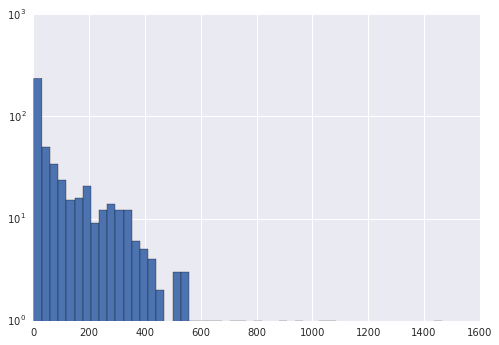

In [9]:
plt.hist(data['fscore'], bins=50)
plt.gca().set_yscale("log")

In [10]:
print data.shape
data.head()

(488, 3)


,feature,fscore,norm_fscore
0,L1_S25_F2131,1,0.000018
1,L3_S30_F3734,1,0.000018
2,L3_S47_F4148,1,0.000018
3,L3_S37_D3947,1,0.000018
4,L0_S12_F334,1,0.000018


In [164]:
tmp = data.feature.apply(lambda x: x.split('_')[2][0])

In [165]:
tmp.value_counts()

F    812
Name: feature, dtype: int64

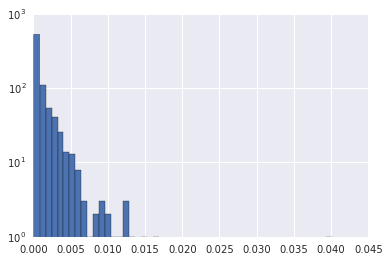

In [151]:
plt.hist(data['norm_fscore'], bins=50)
plt.gca().set_yscale("log")

In [43]:
data_files =  [f for f in os.listdir(data_path) if '.csv' in f]
data = pd.read_csv(join(data_path, data_files[0]), index_col=0)
tmp = data.loc[data['fscore']>10 ,'feature']

In [44]:
data.tail(20)

,feature,fscore,norm_fscore
468,L3_S30_F3804,451,0.008332
469,L3_S33_F3865,453,0.008369
470,L3_S30_F3534,499,0.009219
471,L3_S30_F3809,513,0.009477
472,L0_S0_F0,520,0.009607
473,L0_S0_F2,528,0.009754
474,L3_S29_F3348,547,0.010105
475,L0_S1_F24,553,0.010216
476,L3_S30_F3759,569,0.010512
477,L0_S0_F18,588,0.010863


In [127]:
len(full_union)

736